**Project Tesis Muhammad Azhar Rafi' Samudra**

## **Building Mapping**

In project, we are going to detect the buildings using satellite imagery. It is a binary class segmentation problem.


### **Dataset**
The dataset is taken from Badan Informasi Geospasial (BIG) and restricted use.

Input data are RGB satellite images. And output are binary images. Pixel value is 0 for non-buildings and pixel value is 1 for buildings.



In [1]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install tensorflow==2.20.0


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os

os.chdir(r"##YOUR FOLDER##")
print(os.getcwd())

In [ ]:
import os

files = os.listdir(r"##YOUR FOLDER##")
files

In [5]:
# set the working directory
import os
os.chdir(r"##YOUR FOLDER##")

## **Data Pre-Processing**

In [6]:
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(train_y), len(test_x), len(test_y))

2414 2414 80 80


In [7]:
# converting training image to numpy array
train_xx = np.zeros((2414, 128, 128, 3))
train_yy = np.zeros((2414, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask

In [8]:
# converting testing image to numpy array
test_xx = np.zeros((80, 128, 128, 3))
test_yy = np.zeros((80, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):

  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask

In [ ]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(train_xx[200, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[200, :, :, 0].astype('uint8'))
plt.show()

## **Save to numpy format**

In [10]:
train_xx.shape

(2414, 128, 128, 3)

In [11]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

In [12]:
# Load file numpy
train_xx = np.load('train_xx.npy')
train_yy = np.load('train_yy.npy')
test_xx  = np.load('test_xx.npy')
test_yy  = np.load('test_yy.npy')

# Cek bentuk data (opsional)
print("train_xx shape:", train_xx.shape)
print("train_yy shape:", train_yy.shape)
print("test_xx shape :", test_xx.shape)
print("test_yy shape :", test_yy.shape)

train_xx shape: (2414, 128, 128, 3)
train_yy shape: (2414, 128, 128, 1)
test_xx shape : (80, 128, 128, 3)
test_yy shape : (80, 128, 128, 1)


# **UNet model development**

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Concatenate)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define Model
x_in = Input(shape=(128, 128, 3))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x_temp)

'''Use 1x1 Convolution to get output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

# Define Model
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128, 128, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64, 64, 32)        │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 32)        │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32, 32, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 16, 16, 64)        │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 64)        │          36,928 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 409,281 (1.56 MB)

 Trainable params: 409,281 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Callbacks and Save Best Model
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    train_xx, train_yy,
    validation_data=(test_xx, test_yy),
    epochs=100,
    batch_size=50,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6514 - loss: 0.3112
Epoch 1: val_loss improved from inf to 0.10702, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6528 - loss: 0.3094 - val_accuracy: 0.8489 - val_loss: 0.1070
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8285 - loss: 0.1165
Epoch 2: val_loss improved from 0.10702 to 0.10510, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8286 - loss: 0.1164 - val_accuracy: 0.8504 - val_loss: 0.1051
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8520 - loss: 0.1031
Epoch 3: val_loss improved from 0.10510 to 0.09128, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8522 - loss: 0.1030 - val_accuracy: 0.8702 - val_loss: 0.0913
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8815 - loss: 0.0863
Epoch 4: val_loss improved from 0.09128 to 0.08957, saving model to 

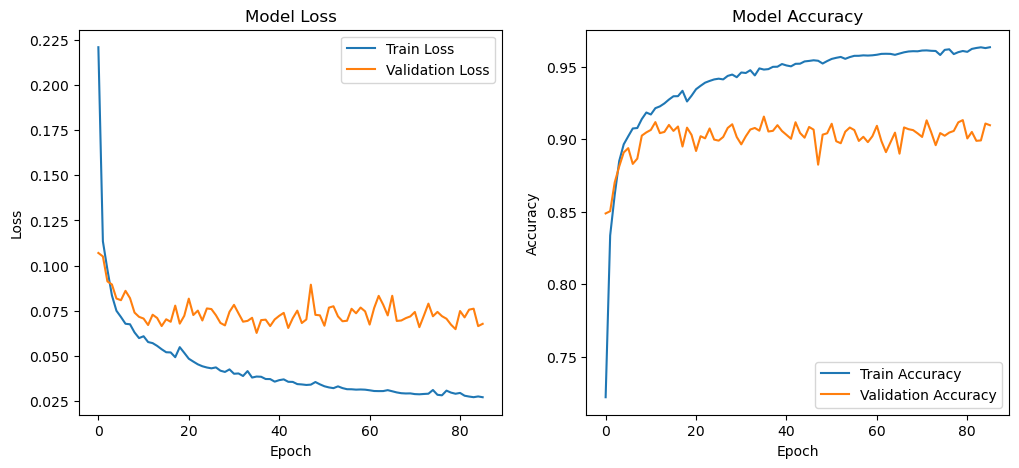

In [15]:
# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# **Prediction**

In [16]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model = load_model("best_model.keras", safe_mode=False)

In [ ]:
# Threshold for binary classification
threshold = 0.3

# Prediction of the output
pred_test = model.predict(test_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

# Plot the images horizontally with titles
plt.figure(figsize=(15, 5))

# Prediction
plt.subplot(1, 2, 1)
plt.imshow(pred_test[15, :, :, 0])
plt.title("Prediction")
plt.axis('off')

# Ground Truth
plt.subplot(1, 2, 2)
plt.imshow(test_yy[15,:,:,0])
plt.title("Ground Truth")
plt.axis('off')

# Display the plots
plt.tight_layout()
plt.show()

## **Convert numpy array to image**

In [18]:
!pip install rasterio


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import rasterio
from rasterio.transform import from_origin
import numpy as np
import os

# Define the output folder for predictions
output_folder = r"##YOUR FOLDER##"
os.makedirs(output_folder, exist_ok=True)

def save_prediction_with_coordinates(pred_array, input_paths, out_folder):
    """
    Save predictions with the same coordinate system and metadata as input images.

    Args:
        pred_array: Numpy array of predictions (n, h, w, 1).
        input_paths: List of paths to input images (georeferenced).
        out_folder: Folder to save the output predictions.
    """
    for i, input_path in enumerate(input_paths):
        # Open the corresponding input image to read its metadata
        with rasterio.open(input_path) as src:
            profile = src.profile  # Copy the metadata
            profile.update({
                "dtype": "uint8",  # Update data type for binary predictions
                "count": 1,        # Single-band output
                "compress": "lzw"  # Optional: compression
            })
            output_path = os.path.join(out_folder, f"{i}_prediction.tif")

            # Save the prediction with the same georeferencing information
            with rasterio.open(output_path, "w", **profile) as dst:
                dst.write(pred_array[i, :, :, 0].astype("uint8"), 1)

# Save predictions with georeferencing
save_prediction_with_coordinates(pred_test, test_x, output_folder)

In [ ]:
import rasterio
from rasterio.merge import merge
import glob
import os

def merge_predictions(output_folder, merged_output_path):
    """
    Merge all georeferenced prediction tiles into a single raster.

    Args:
        output_folder: Folder containing individual prediction tiles.
        merged_output_path: Path to save the merged raster.
    """
    # Find all GeoTIFF files in the output folder
    tile_paths = sorted(glob.glob(os.path.join(output_folder, "*.tif")))

    # Open all the tiles
    src_files_to_mosaic = []
    for tile_path in tile_paths:
        src = rasterio.open(tile_path)
        src_files_to_mosaic.append(src)

    # Merge tiles
    mosaic, out_transform = merge(src_files_to_mosaic)

    # Use the metadata of the first tile as a base
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "count": 1  # Single band
    })

    # Save the merged raster
    with rasterio.open(merged_output_path, "w", **out_meta) as dest:
        dest.write(mosaic[0], 1)

    # Close all opened tiles
    for src in src_files_to_mosaic:
        src.close()

# Folder containing prediction tiles
output_folder = r"##YOUR FOLDER##"

# Path to save the merged raster
merged_output_path = r"##YOUR FOLDER##"

# Merge prediction tiles
merge_predictions(output_folder, merged_output_path)

print(f"Merged raster saved at {merged_output_path}")
